In [1]:
import datetime
import os
import mthree
import numpy as np
from qiskit import IBMQ
from qiskit.providers.ibmq import IBMQBackend 
from qiskit.providers.aer import AerSimulator
from qiskit_research.mzm_generation import KitaevHamiltonianExperiment
from qiskit_research.mzm_generation.utils import pick_qubit_layout, orbital_combinations

In [2]:
# get backend

# hardware backend
# IBMQ.load_account()
# provider = IBMQ.get_provider(hub='ibm-q-internal', group='deployed', project='default')
# backend = provider.get_backend('ibmq_guadalupe')

# Aer simulator backend
backend = AerSimulator(method='statevector')

In [3]:
# Hamiltonian parameters
n_modes = 3
tunneling_values = [-1.0]
superconducting_values = [1.0]
chemical_potential_values = np.linspace(1e-8, 3.1, num=5)
occupied_orbitals_list = list(orbital_combinations(n_modes, threshold=None))

# qubits
# qubits, backend_name, error_score = pick_qubit_layout(n_modes, [backend])
qubits = list(range(n_modes))
print(f'Using qubits {qubits}.')

# number of shots
shots = 10000

# number of shots for readout error calibration
readout_calibration_shots = 10000

# date
date = datetime.datetime.now().isoformat()

# create experiments
experiment = KitaevHamiltonianExperiment(
    experiment_id=f'{date}_{backend.name()}',
    backend=backend,
    readout_calibration_date=date,
    qubits=qubits,
    tunneling_values=tunneling_values,
    superconducting_values=superconducting_values,
    chemical_potential_values=chemical_potential_values,
    occupied_orbitals_list=occupied_orbitals_list,
    # dynamical_decoupling_sequences=['X2pm', 'XY4pm']
)

Using qubits [0, 1, 2].


In [4]:
%%time

# schedule readout calibration
print('Scheduling readout calibration ...')
mit = mthree.M3Mitigation(backend)
mit.cals_from_system(qubits, shots=readout_calibration_shots)
# schedule experiment jobs
circuits_per_job = 100
print(f'Scheduling experiment ...')
# limit number of circuits per job to avoid timeouts
backend.configuration().max_experiments = 100
data = experiment.run(shots=shots)
if isinstance(backend, IBMQBackend):
    data.save()

# save readout calibration
filename = f'data/readout_calibration/{backend.name()}/{date}.json'
os.makedirs(os.path.dirname(filename), exist_ok=True)
print(f'Waiting for readout calibration data ...')
mit.cals_to_file(filename)
print(f'Readout calibration saved.')

Scheduling readout calibration ...
Scheduling experiment ...
Waiting for readout calibration data ...
Readout calibration saved.
CPU times: user 10.7 s, sys: 122 ms, total: 10.9 s
Wall time: 11.1 s


In [5]:
# wait for experiment results
# data.block_for_results()

# TODO save data locally once it's supported
# See https://github.com/Qiskit/qiskit-experiments/issues/602

In [6]:
# TODO split off into analysis notebook once Qiskit Experiments supports saving data
# See https://github.com/Qiskit/qiskit-experiments/issues/602
import os
import matplotlib.pyplot as plt
import numpy as np
from qiskit import IBMQ
from qiskit_experiments.framework import ExperimentData
from qiskit_nature.mappers.second_quantization import JordanWignerMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter
from qiskit_research.mzm_generation import KitaevHamiltonianAnalysis

In [7]:
%%time
experiment_id = data.metadata["experiment_id"]
qubits = data.metadata["qubits"]
n_modes = len(qubits)
tunneling_values = data.metadata["tunneling_values"]
superconducting_values = data.metadata["superconducting_values"]
chemical_potential_values = data.metadata["chemical_potential_values"]

# run analysis
analysis = KitaevHamiltonianAnalysis()
data = analysis.run(data)

bdg_energy_exact = data.analysis_results('bdg_energy_exact').value
bdg_energy_raw, bdg_energy_stddev_raw = data.analysis_results('bdg_energy_raw').value
bdg_energy_mem, bdg_energy_stddev_mem = data.analysis_results('bdg_energy_mem').value
bdg_energy_ps, bdg_energy_stddev_ps = data.analysis_results('bdg_energy_ps').value
bdg_energy_pur, bdg_energy_stddev_pur = data.analysis_results('bdg_energy_pur').value

# site_correlation_exact = data.analysis_results('site_correlation_exact').value

# create plot directory
os.makedirs(f'plots/{experiment_id}', exist_ok=True)

# set plot options
dpi = 150
filetype = 'png'

/home/kjs/projects/qiskit-research/qiskit_research/mzm_generation/utils.py:68: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  return FermionicOp(f"-_{index}") + FermionicOp(f"+_{index}")


CPU times: user 41.6 s, sys: 773 ms, total: 42.4 s
Wall time: 16.9 s


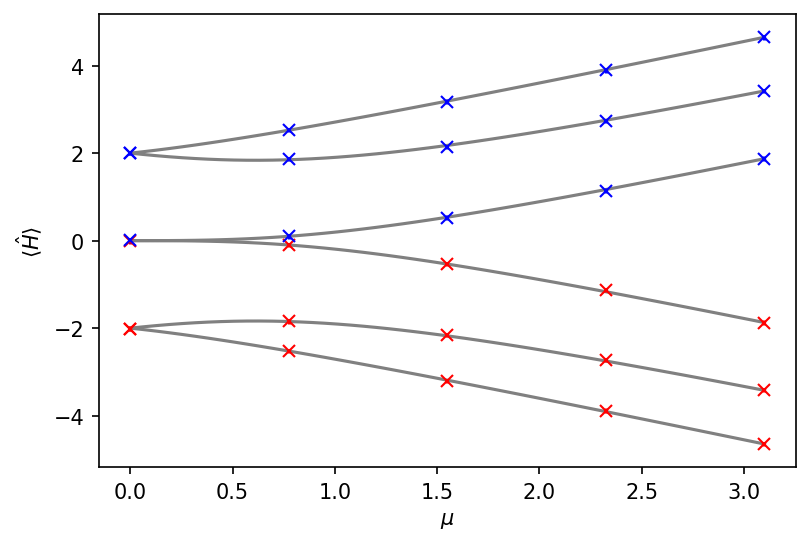

In [ ]:
# plot BdG energies
fig, ax = plt.subplots(dpi=150)
for energies in bdg_energy_exact[0]:
    ax.plot(
        bdg_energy_exact[1], energies, color='gray'
    )
threshold = len(bdg_energy_raw) // 2
for i in range(threshold):
    ax.errorbar(
        chemical_potential_values,
        bdg_energy_raw[i],
        yerr=2 * bdg_energy_stddev_raw[i],
        fmt='x',
        color='red'
    )
    ax.errorbar(
        chemical_potential_values,
        bdg_energy_raw[threshold + i],
        yerr=2 * bdg_energy_stddev_raw[threshold + i],
        fmt='x',
        color='blue'
    )
ax.set_xlabel(r"$\mu$")
ax.set_ylabel(r"$\langle \hat{H} \rangle$")

plt.show()